# **Model and Evaluation**

## Objectives

* Create Train and Test set and Machine Learning Pipeline to answer the second business requirement which is:
    * The client is interested in predicting the house sale price from her four inherited houses and any other house in Ames, Iowa.

## Inputs

* The clean and feature engineered datasets are located at: outputs/dataset/collection

## Outputs

* Train set (features and target)* 
Test set (features and target
* Modeling Pipeline. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Fabrizio-Project-Five/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/Fabrizio-Project-Five'

Before starting our model notebook we will create a cell where we will place all of our imports

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
# Feature Engineering
from feature_engine.selection import SmartCorrelatedSelection
# Feature Scaling
from sklearn.preprocessing import StandardScaler
# Feature Selection
from sklearn.feature_selection import SelectFromModel
# Import GridSearchCV for model score evaluation
from sklearn.model_selection import GridSearchCV
# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
# metrics for model evaluation
from sklearn.metrics import r2_score

# Splitting the Dataset

In this section we will split the dataset in Train and Test set in order to prepare it for model training. The test set will be 20% of the whole dataset just to make sure we are adherent to ML initial best practices.

In [5]:
df_fe = pd.read_csv('outputs/dataset/collection/feature_engineered_dataset.csv')
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379 entries, 0 to 1378
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   1stFlrSF           1379 non-null   int64  
 1   2ndFlrSF           1379 non-null   float64
 2   BedroomAbvGr       1379 non-null   float64
 3   BsmtFinSF1         1379 non-null   int64  
 4   BsmtUnfSF          1379 non-null   int64  
 5   EnclosedPorch      1379 non-null   float64
 6   GarageArea         1379 non-null   int64  
 7   GarageYrBlt        1379 non-null   float64
 8   GrLivArea          1379 non-null   int64  
 9   LotArea            1379 non-null   int64  
 10  LotFrontage        1379 non-null   float64
 11  MasVnrArea         1379 non-null   float64
 12  OpenPorchSF        1379 non-null   int64  
 13  OverallCond        1379 non-null   int64  
 14  OverallQual        1379 non-null   int64  
 15  TotalBsmtSF        1379 non-null   int64  
 16  WoodDeckSF         1379 

In [6]:
X = df_fe.drop('SalePrice', axis=1)
y = df_fe['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=9)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1103, 38) (1103,) 
* Test set: (276, 38) (276,)


As we can see from the result of the .shape attribute called on the various test and train datasets we have achieved our goal. Now we can move on to the ML Pipeline itself.

---

# Regression Pipeline

In this section we will study which regression algorithm is the best one fo our ML business case. The results from the algorithm will also provide us with information that we can use to determine if additional hyperparameter optimization will be needed.

In this cell I have imported code from the Churnometer Walkthrough Project. These two dictionaries list first the type of regression
model we want to try for our ML business case and second a dictionary which will run a search for the default hyperparameters for each model

In [7]:
# Code from the Churnometer Walkthrough Project

models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In the next cell I will import a custom class from the Churnometer Project. Specifically this class will fit all the models listed in the in the previous dictionary and will apply the default hyperparameters (again, as listed in the previous dictionary). The class will also return a DataFrame with the scores for the regression models. This will allow us to select the best model for our Business Case.

In [8]:
# Code from Churnometer Walkthrough Project
class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = regression_pipeline(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

In the next cell we will instantiate the Pipeline. The estimators will be described as well.

In [9]:
def regression_pipeline(model):
    pipeline_base = Pipeline([
        # The SmartCorrelatedSelection is set with a threshold of 0.5 given our previous correlation study
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.5, selection_method="variance")),
        # The feature scaling transformer has been applied because there were features with different units in the clean dataset 
        ("feature_scaling", StandardScaler()),
        # This transformer will select the best feature for prediction
        ("feature_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base    

In [10]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

In [11]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
2,RandomForestRegressor,0.648496,0.810041,0.871683,0.083003
5,GradientBoostingRegressor,0.604829,0.799303,0.883576,0.10349
3,ExtraTreesRegressor,0.636204,0.792815,0.866195,0.082968
6,XGBRegressor,0.590773,0.769973,0.84175,0.096288
4,AdaBoostRegressor,0.58557,0.734755,0.801624,0.077731
0,LinearRegression,0.386619,0.721743,0.832828,0.170149
1,DecisionTreeRegressor,0.318006,0.607837,0.742074,0.151197


In the above cell we can see that the best regressor for our business case is the 'Random Forest Regressor'. The mean score for 'R2' is already above the 0.75 value that we set as our goal. Nonetheless we can still conduct a more in-depth hyperparameter search to look for a fine tuned model that could give us even a more precise outcome.

In [12]:
models_quick_search = {
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}

params_quick_search = {
    'RandomForestRegressor': {
        'model__n_estimators': [10, 50, 100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10, 20]
    }
}

In [13]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=10)


Running GridSearchCV for RandomForestRegressor 

Fitting 10 folds for each of 80 candidates, totalling 800 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

In [14]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary.query('mean_score > 0.80')

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_split,model__n_estimators
28,RandomForestRegressor,0.526597,0.810677,0.883189,0.100239,10,5,200
29,RandomForestRegressor,0.517744,0.810264,0.887177,0.103023,10,5,300
48,RandomForestRegressor,0.519981,0.80957,0.884144,0.102049,20,5,200
8,RandomForestRegressor,0.519461,0.809536,0.884866,0.10222,None,5,200
68,RandomForestRegressor,0.519461,0.809536,0.884866,0.10222,30,5,200
23,RandomForestRegressor,0.483393,0.809202,0.899432,0.114425,10,2,200
9,RandomForestRegressor,0.513994,0.80917,0.88786,0.103917,None,5,300
69,RandomForestRegressor,0.513994,0.80917,0.88786,0.103917,30,5,300
43,RandomForestRegressor,0.478917,0.80914,0.898937,0.115369,20,2,200
49,RandomForestRegressor,0.513624,0.809103,0.887497,0.104002,20,5,300


As we can see from our previous cells, even after 640 fits of our pipeline the best hyperparameters were found on the very first fit. 

* Model max depth: The best value for this hyperparameter is 10. That means that the algorithm ran until the trees in the forest reached a depth of 10
* Minimum sample split: The best value for this is 5. This means that 5 was the minimum number of samples required to split and internal node.
* Number of Estimators: The best value for this is 200. This means that we had 200 trees in our forest.

Now if we run the next cell we have our best regression pipeline, including the hyperparameters that gave us the best R2 score.

In [15]:
best_model = grid_search_summary.iloc[0,0]
grid_search_pipelines[best_model].best_params_
regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
regressor_pipeline

Pipeline(steps=[('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.5,
                                          variables=['1stFlrSF', '2ndFlrSF',
                                                     'BedroomAbvGr',
                                                     'BsmtFinSF1', 'BsmtUnfSF',
                                                     'EnclosedPorch',
                                                     'GarageArea',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'LotArea', 'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond',
                                        

After having found our best pipeline we need to evaluate the performance using the metrics we have decided in our business case assesment. 

In [16]:
prediction = regressor_pipeline.predict(X_train)
regression_r2_metric = r2_score(y_train, prediction)
test_set_prediction = regressor_pipeline.predict(X_test)
r2_metric_test_set = r2_score(y_test, test_set_prediction)
print('r2 metric on train set: ', regression_r2_metric, '\n'
      'r2 metric on test set: ', r2_metric_test_set)
    

r2 metric on train set:  0.956998034200152 
r2 metric on test set:  0.672548468507699


Our r2 score for the test set is too low while on the train set is too high. A classic case of overfitting. Our best move now is to tweak our hyperparameters to see if the pipeline will give us a test set r2 score that we can accept. In addition to that we will also set the threshold for our Smart Correlated Selection to 0.8 compared to the previous 0.5

In [17]:
def regression_pipeline(model):
    pipeline_base = Pipeline([
        # The SmartCorrelatedSelection is set with a threshold of 0.8 given our previous correlation study
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.8, selection_method="variance")),
        # The feature scaling transformer has been applied because there were features with different units in the clean dataset 
        ("feature_scaling", StandardScaler()),
        # This transformer will select the best feature for prediction
        ("feature_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base 

In [18]:
models_quick_search = {
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
}

params_quick_search = {
    'RandomForestRegressor': {
        'model__n_estimators': [10, 50, 100],
        'model__max_depth': [10, 20, 30],
        'model__min_samples_split': [2, 5, 10, 20]
    }
}

# For reference these below were our previous hyperparameters
"""
params_quick_search = {
    'RandomForestRegressor': {
        'model__n_estimators': [10, 50, 100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10, 20]
    }
}
"""

"\nparams_quick_search = {\n    'RandomForestRegressor': {\n        'model__n_estimators': [10, 50, 100, 200, 300],\n        'model__max_depth': [None, 10, 20, 30],\n        'model__min_samples_split': [2, 5, 10, 20]\n    }\n}\n"

In [19]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

In [20]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_split,model__n_estimators
4,RandomForestRegressor,0.718967,0.825774,0.866052,0.056086,10,5,50
1,RandomForestRegressor,0.704438,0.825306,0.872483,0.063131,10,2,50
16,RandomForestRegressor,0.728027,0.825255,0.86475,0.051827,20,5,50
28,RandomForestRegressor,0.728127,0.825178,0.864902,0.051797,30,5,50
17,RandomForestRegressor,0.724452,0.823822,0.8661,0.052931,20,5,100
5,RandomForestRegressor,0.715429,0.82369,0.866122,0.056954,10,5,100
29,RandomForestRegressor,0.724303,0.823612,0.866144,0.052928,30,5,100
2,RandomForestRegressor,0.696545,0.823023,0.867797,0.065881,10,2,100
19,RandomForestRegressor,0.7366,0.822608,0.866532,0.046695,20,10,50
31,RandomForestRegressor,0.7366,0.822569,0.866315,0.046657,30,10,50


Now that we have a new best set of hyperparameters we can run our r2 score evaluation again.

In [21]:
best_model = grid_search_summary.iloc[0,0]
grid_search_pipelines[best_model].best_params_
regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
regressor_pipeline

Pipeline(steps=[('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          variables=['1stFlrSF', '2ndFlrSF',
                                                     'BedroomAbvGr',
                                                     'BsmtFinSF1', 'BsmtUnfSF',
                                                     'EnclosedPorch',
                                                     'GarageArea',
                                                     'GarageYrBlt', 'GrLivArea',
                                                     'LotArea', 'LotFrontage',
                                                     'MasVnrArea',
                                                     'OpenPorchSF',
                                                     'OverallCond',
                                                     'OverallQual',
                             

In [22]:
train_set_prediction = regressor_pipeline.predict(X_train)
regression_r2_metric = r2_score(y_train, train_set_prediction)
test_set_prediction = regressor_pipeline.predict(X_test)
r2_metric_test_set = r2_score(y_test, test_set_prediction)
print('r2 metric on train set: ', regression_r2_metric, '\n'
      'r2 metric on test set: ', r2_metric_test_set)

r2 metric on train set:  0.9553443457943921 
r2 metric on test set:  0.7643923167360736


Finally we were able to have an r2 score above 0.75 on both train and test set. The difference in the 2 values still shows us some overfitting. In future iterations of the pipeline we could analyze what is causing this and try to fix it. 

Now we can plot the most important features that the pipeline was able to find.

In [25]:
scs = SmartCorrelatedSelection(threshold=0.8, method='spearman', selection_method='variance')
best_feature_mask = regressor_pipeline['feature_selection'].get_support()
scs_features = scs.fit_transform(df_fe).columns
pipeline_best_features = [feature for feature, is_selected in zip(scs_features, best_feature_mask) if is_selected]
# pipeline_best_features
# regressor_pipeline['model'].feature_importances_
best_features_df = pd.DataFrame(data={
    'Features' : pipeline_best_features,
    'Importance': regressor_pipeline['model'].feature_importances_
}).sort_values(by='Importance', ascending=False)
best_features_df

/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passi

,Features,Importance
3,TotalBsmtSF,0.604635
2,GrLivArea,0.170938
4,WoodDeckSF,0.077942
1,BsmtFinSF1,0.076672
0,2ndFlrSF,0.069813


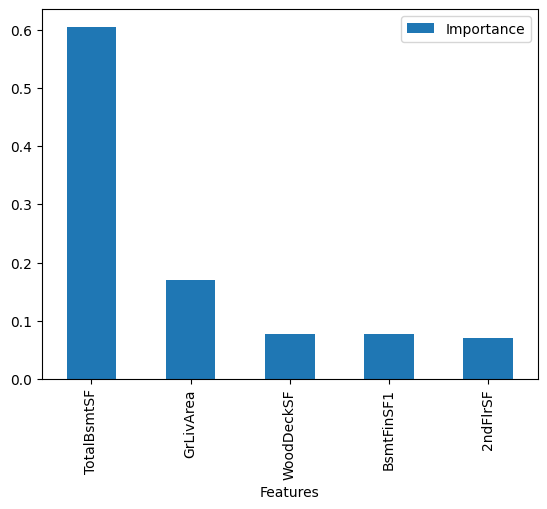

In [30]:
best_features_df.plot(kind='bar', x='Features', y='Importance')
plt.show()

---

---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
